In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
#ignore warnigns
import warnings
warnings.filterwarnings("ignore")


tf.random.set_seed(42) # For reproducibility
# Generate some random numbers
a = tf.random.uniform([1], seed=42)
b = tf.random.uniform([1], seed=42)

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense,Embedding,Dropout, LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

#metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

import sys
sys.executable


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2024-01-01 00:29:33.422782: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


'/opt/anaconda3/envs/tf/bin/python'

In [3]:
import matplotlib.pyplot as plt
#!pip install seaborn
import seaborn as sns

In [4]:
from tensorflow.keras.callbacks import LearningRateScheduler


In [5]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.visible_device_list = "0"
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.5
tf.compat.v1.Session(config=config)

In [6]:
# Including MLflow
import mlflow
import mlflow.tensorflow
import os

In [7]:
#keras
from keras import backend as K

In [8]:
physical_devices = tf.config.list_physical_devices('GPU')

In [9]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8614902505641988167
xla_global_id: -1
]


In [10]:
#creating train_test data
target = pd.read_csv('/Users/gloriacarrascal/trabajo-grado/data/scaled_target_from2012.csv')
features = pd.read_csv('/Users/gloriacarrascal/trabajo-grado/data/scaled_features_from2012.csv', parse_dates=['Datetime'])

In [11]:
features.shape

(1086, 10)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(features[['altitud', 'longitud', 'dirviento', 'nubosidad', 'temperatura', 'vapor', 'rocio']], target, test_size=0.3, random_state=42)

In [14]:
def loos_visualization(history, num_model):
    # You can also visualize the training history to check for overfitting

    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f'/Users/gloriacarrascal/trabajo-grado/graficas/Conv_model_{num_model}.png')
    plt.show()

In [15]:
tf_graph = tf.Graph()
tf_sess = tf.compat.v1.Session(graph=tf_graph)

In [16]:
mlflow.tensorflow.autolog(every_n_iter=2)

In [17]:
def learning_vs_loss(history, num_model, lr_schedule):
    learning_rates = [lr_schedule(epoch, 1e-3) for epoch in range(len(history.history['loss']))]
    losses = history.history['loss']


    plt.plot(learning_rates, losses)
    plt.xscale('log')
    plt.xlabel('Learning Rate (log scale)')
    plt.ylabel('Loss')
    plt.savefig(f'/Users/gloriacarrascal/trabajo-grado/graficas/learning_rate_vs_loss_{num_model}.png')
    plt.show()

In [18]:
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.callbacks import LearningRateScheduler
from keras.layers import BatchNormalization


In [19]:
X_train.shape[2]

IndexError: tuple index out of range

In [20]:
def create_combined_model(exp_name, input_shape, learning_rate):
  

    # CNN model for spatial feature extraction
    cnn_model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(80, 3, activation='relu', input_shape=(X_train.shape[1], 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling1D(pool_size=1),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(200, activation='relu')
    ])

    # LSTM model for capturing temporal dependencies
    lstm_model = tf.keras.Sequential([
        tf.keras.layers.LSTM(64, activation='relu', return_sequences=True),
        tf.keras.layers.LSTM(32, activation='relu', return_sequences=False),
        tf.keras.layers.Dropout(0.2)
    ])

    # Combine both CNN and LSTM models
    combined_model = tf.keras.Sequential([
        tf.keras.layers.TimeDistributed(cnn_model,),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten()),  # TimeDistributed layer to apply CNN across time steps
        lstm_model,
        tf.keras.layers.Dense(1, activation='linear')  # Output layer
    ])

    combined_model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

    history_combined = combined_model.fit(input_shape, y_train,epochs=20, batch_size=32, validation_split=0.2, callbacks=[early_stopping])
  
    mlflow.set_experiment(exp_name)

    with mlflow.start_run():

        # #y_pred = combined_model.predict(X_test[:0], 1)
        # # # evaluate the model
        # mse = mean_squared_error(y_test,y_pred[:, 0])
        # print(f"Mean Squared Error (MSE): {mse}")
        # rmse = np.sqrt(mse)
        # print(f"Root Squared Error (RMSE): {rmse}")
        # mae = mean_absolute_error(y_test, y_pred[:, 0])
        # print(f"Mean Absolute Error (MAE): {mae}")
        # r2 = r2_score(y_test, y_pred[:, 0])
        # print(f"R squared (R2): {r2}")
        # mape = mean_absolute_percentage_error(y_test, y_pred[:, 0])
        # print(f"Mean Absolute Percentage Error (MAPE): {mape}")
        # mlflow.log_metric("Mean Squared Error_MSE", mse)
        # mlflow.log_metric("Root Squared Error_RMSE", rmse)
        # mlflow.log_metric("Mean Absolute Error_MAE", mae)
        # mlflow.log_metric("R squared_R2", r2)
        mlflow.log_metric("Mean Absolute Percentage Error_MAPE", 3)

    return history_combined, combined_model

In [21]:
# Define the input shape based on your sliced data
input_shape = X_train.values

In [22]:
input_shape.shape

(760, 7)

In [23]:

# Assuming X_train is your DataFrame with 7 columns
X_train_array = X_train.values

# Define the desired number of features and time steps
num_features = X_train_array.shape[1]  # Number of columns in the DataFrame (7 in this case)
desired_time_steps = 10

# Ensure the number of features is greater than 0 and adjust time steps accordingly
if num_features > 0:
    time_steps = max(1, num_features // desired_time_steps)
    adjusted_time_steps = max(1, num_features // time_steps)
    
    # Reshape the array into (samples, time steps, features) format
    X_train_reshaped = X_train_array.reshape(-1, time_steps, adjusted_time_steps)

    # Check the shape of the reshaped array
    print(X_train_reshaped.shape)
else:
    raise ValueError("Number of features should be greater than 0.")


(760, 1, 7)


In [24]:
(X_train_reshaped[0], X_train_reshaped[2])

(array([[ 0.32917925,  0.4378372 , -0.84931708, -0.69768946, -1.10638123,
         -0.78319027, -0.74496435]]),
 array([[ 0.03713957, -0.14248342,  0.55024952,  0.64985486, -0.08247365,
          1.17617009,  1.16420595]]))

In [25]:
type(X_train_reshaped[1:])

numpy.ndarray

In [26]:
(X_train.shape[1], 1)

(7, 1)

In [27]:
history, model = create_combined_model('combined model', input_shape= X_train_reshaped, learning_rate= 0.001 )

2024/01/01 00:30:29 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'f34884608cea4f8382eae6b3ec2b735a', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2024/01/01 00:30:29 WARNING mlflow.tensorflow: Encountered unexpected error while inferring batch size from training dataset: 'Sequential' object has no attribute '_nested_inputs'
2024/01/01 00:30:29 WARNING mlflow.tensorflow: Failed to log training dataset information to MLflow Tracking. Reason: 'DataFrame' object has no attribute 'flatten'


Epoch 1/20
19/19 [==============================] - 2s 25ms/step - loss: 0.5821 - val_loss: 0.9097
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 0.1775 - val_loss: 0.8518
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 0.1119 - val_loss: 0.7936
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 0.0918 - val_loss: 0.7224
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 0.0778 - val_loss: 0.6224
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 0.0773 - val_loss: 0.5694
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 0.0673 - val_loss: 0.4228
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 0.0637 - val_loss: 0.3383
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 0.0658 - val_loss: 0.2725
Epoch 10/20
19/19 [==============================] - 0s 3ms/step - loss: 0.0645 - val_loss: 0.1559
Epoch 11/20
19/19 

2024-01-01 00:30:33.968003: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,7]
	 [[{{node inputs}}]]
2024-01-01 00:30:33.973662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,7]
	 [[{{node inputs}}]]
2024-01-01 00:30:34.001830: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,200]
	 [[{{node inputs}}]]
2024-01-01 00:

INFO:tensorflow:Assets written to: /var/folders/_8/stsrqpjs1q1559jp3dtpqv0c0000gn/T/tmp7lqckzs_/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/_8/stsrqpjs1q1559jp3dtpqv0c0000gn/T/tmp7lqckzs_/model/data/model/assets


In [28]:
X_test_array = X_test.values

# Define the desired number of features and time steps
num_features = X_test_array.shape
num_features

(326, 7)

In [30]:
# Assuming X_train is your DataFrame with 7 columns
X_test_array = X_test.values

# Define the desired number of features and time steps
num_features = X_test_array.shape[1] # Number of columns in the DataFrame (7 in this case)
desired_time_steps = 10

# Ensure the number of features is greater than 0 and adjust time steps accordingly
if num_features > 0:
    time_steps = max(1, num_features // desired_time_steps)
    djusted_time_steps = max(1, num_features // time_steps)
    
    # Reshape the array into (samples, time steps, features) format
    X_test_reshaped = X_test_array.reshape(-1, time_steps, adjusted_time_steps)

    # Check the shape of the reshaped array
    print(X_test_reshaped.shape)
else:
    raise ValueError("Number of features should be greater than 0.")


(326, 1, 7)


In [31]:
y_pred = model.predict(X_test_reshaped)

11/11 [==============================] - 0s 959us/step


In [32]:
r2 = r2_score(y_test, y_pred)
print(f"R squared (R2): {r2}")

R squared (R2): 0.9584924289892003


In [33]:
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Mean Absolute Percentage Error (MAPE): {mape}")

Mean Absolute Percentage Error (MAPE): 0.15297804253318173


In [34]:
_pred = pd.DataFrame(y_pred, columns=['irradiancia'])

In [35]:
_pred.to_csv('/Users/gloriacarrascal/trabajo-grado/data/ConvLSTM_prediction_irradiancia_2018.csv', index=False)


In [36]:
y_test.to_csv('/Users/gloriacarrascal/trabajo-grado/data/y_test_ConvLSTM_prediction_irradiancia_2018.csv', index=False)


In [ ]:
#evaluate model sensitivity outliers

In [35]:
_pred.shape

(326, 1)

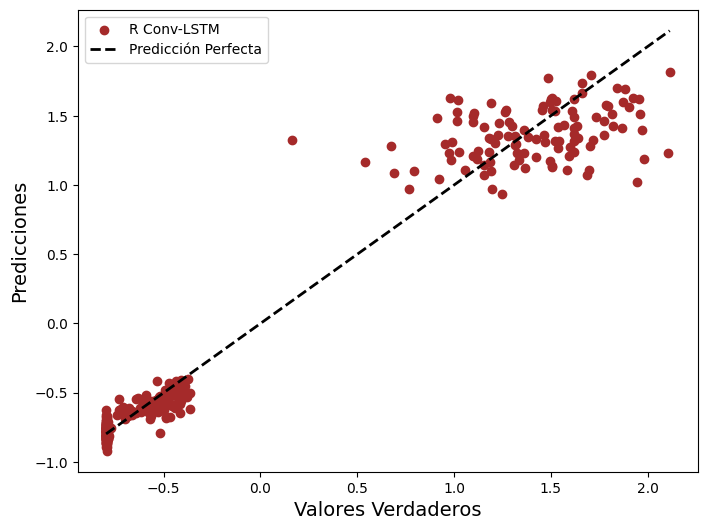

In [38]:
import numpy as np
import matplotlib.pyplot as plt
#from sklearn.metrics import r2_score


# Calculate the R-squared score
r_squared = r2_score(y_test, y_pred)

# Create a scatter plot of true vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, c='brown', label=f'R Conv-LSTM')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, c='black', label='Predicción Perfecta')
plt.xlabel('Valores Verdaderos', fontsize=14)
plt.ylabel('Predicciones', fontsize=14)
#plt.title(f'R = {r_squared:.2f}')
plt.legend()
#plt.savefig(f'/Users/gloriacarrascal/trabajo-grado/graficas/r_squared_CONVFNN.png')
plt.show()


In [39]:
# # evaluate the model
mse = mean_squared_error(y_test,y_pred[:, 0])
print(f"Mean Squared Error (MSE): {mse}")
rmse = np.sqrt(mse)
print(f"Root Squared Error (RMSE): {rmse}")
mae = mean_absolute_error(y_test, y_pred[:, 0])
print(f"Mean Absolute Error (MAE): {mae}")
r2 = r2_score(y_test, y_pred[:, 0])
print(f"R squared (R2): {r2}")

Mean Squared Error (MSE): 0.04295175650370269
Root Squared Error (RMSE): 0.20724805548835118
Mean Absolute Error (MAE): 0.12930192048665182
R squared (R2): 0.9584924289892003


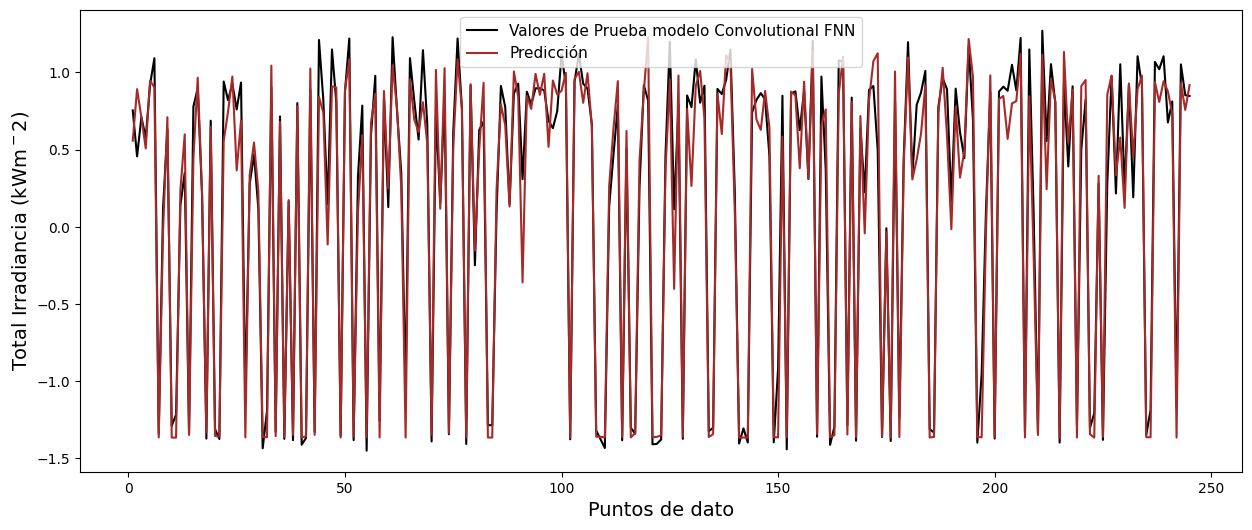

In [23]:
x_axis = np.arange(1, len(y_test) + 1)

# Create a line chart for y_true and y_pred
plt.figure(figsize=(15,6), dpi=100)
plt.plot(x_axis, y_pred4, label='Valores de Prueba modelo Convolutional FNN',linestyle='-', color='black')
plt.plot(x_axis, y_test, label='Predicción',linestyle='-', color='brown')
plt.xlabel('Puntos de dato', fontsize=14)
plt.ylabel('Total Irradiancia (kWm$^-2$)', fontsize=14)
#plt.title('Valor vs. Predicted Values')
plt.legend(loc='upper center', fontsize=11)
plt.grid(False)
plt.savefig(f'/Users/gloriacarrascal/trabajo-grado/graficas/timeserie_CONVFNN.png')
plt.show()


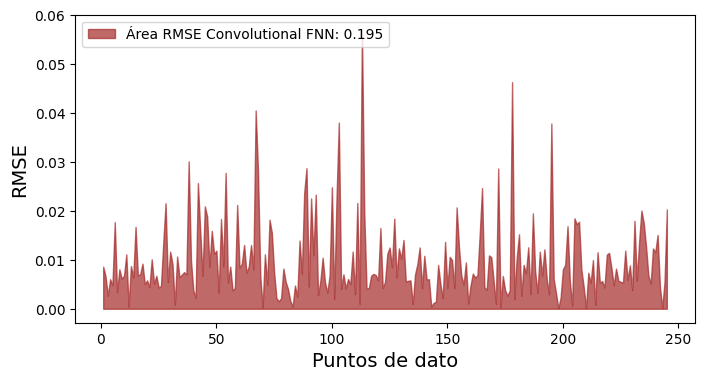

In [198]:
rmse = np.sqrt((y_test - y_pred4)**2 /len(y_test)) 


# Create an array for the x-axis (e.g., time or data points)
x_axis = np.arange(1, len(y_test) + 1)
# Reshape the multidimensional array to one dimension
rmse = rmse.to_numpy().flatten()

# Create a filled area plot of MAE over time
plt.figure(figsize=(8, 4))
plt.fill_between(x_axis, 0, rmse, alpha=0.7, color='brown', label='Área RMSE Convolutional FNN: 0.195')
plt.xlabel('Puntos de dato', fontsize=14)
plt.ylabel('RMSE', fontsize=14)
#plt.title('Mean Absolute Error (MAE) Between y_test and y_pred')
plt.legend(loc='upper left', fontsize=10)
plt.grid(False)
plt.savefig(f'/Users/gloriacarrascal/trabajo-grado/graficas/RMSE_CONVFNN.png')
plt.show()


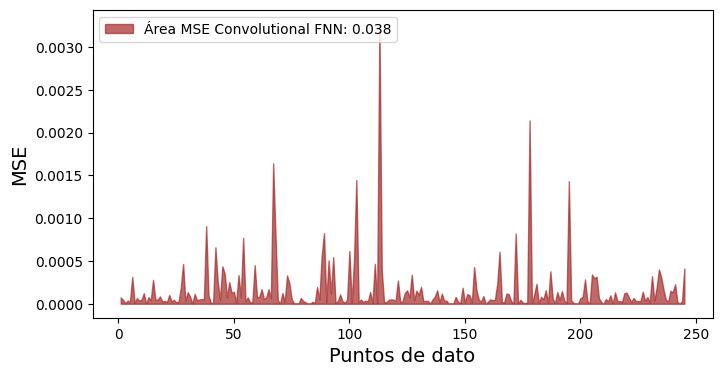

In [199]:
mse = (y_test - y_pred4)**2 /len(y_test)


# Create an array for the x-axis (e.g., time or data points)
x_axis = np.arange(1, len(y_test) + 1)
# Reshape the multidimensional array to one dimension
mse = mse.to_numpy().flatten()

# Create a filled area plot of MAE over time
plt.figure(figsize=(8, 4))
plt.fill_between(x_axis, 0, mse, alpha=0.7, color='brown', label='Área MSE Convolutional FNN: 0.038')
plt.xlabel('Puntos de dato', fontsize=14)
plt.ylabel('MSE', fontsize=14)
#plt.title('Mean Absolute Error (MAE) Between y_test and y_pred')
plt.legend(loc='upper left', fontsize=10)
plt.grid(False)
plt.savefig(f'/Users/gloriacarrascal/trabajo-grado/graficas/MSE_CONVFNN.png')
plt.show()

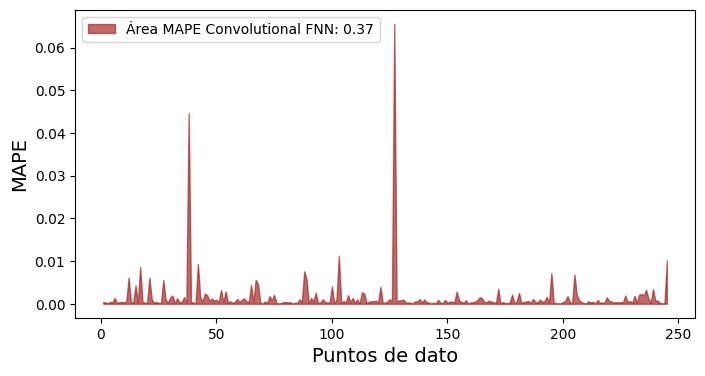

In [202]:
mape = np.abs((y_test - y_pred4)/y_test)/(len(y_test))


# Create an array for the x-axis (e.g., time or data points)
x_axis = np.arange(1, len(y_test) + 1)
# Reshape the multidimensional array to one dimension
mape = mape.to_numpy().flatten()

# Create a filled area plot of MAE over time
plt.figure(figsize=(8, 4))
plt.fill_between(x_axis, 0, mape, alpha=0.7, color='brown', label='Área MAPE Convolutional FNN: 0.37')
plt.xlabel('Puntos de dato', fontsize=14)
plt.ylabel('MAPE', fontsize=14)
#plt.title('Mean Absolute Error (MAE) Between y_test and y_pred')
plt.legend(loc='upper left', fontsize=10)
plt.grid(False)
plt.savefig(f'/Users/gloriacarrascal/trabajo-grado/graficas/MAPE_CONVFNN.png')
plt.show()

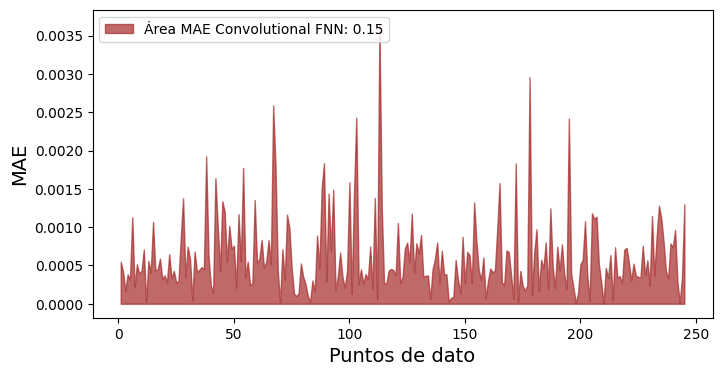

In [204]:
mae = np.abs(y_test - y_pred4)/len(y_test)


# Create an array for the x-axis (e.g., time or data points)
x_axis = np.arange(1, len(y_test) + 1)
# Reshape the multidimensional array to one dimension
mae = mae.to_numpy().flatten()

# Create a filled area plot of MAE over time
plt.figure(figsize=(8, 4))
plt.fill_between(x_axis, 0, mae, alpha=0.7, color='brown', label='Área MAE Convolutional FNN: 0.15')
plt.xlabel('Puntos de dato', fontsize=14)
plt.ylabel('MAE', fontsize=14)
#plt.title('Mean Absolute Error (MAE) Between y_test and y_pred')
plt.legend(loc='upper left', fontsize=10)
plt.grid(False)
plt.savefig(f'/Users/gloriacarrascal/trabajo-grado/graficas/MAE_CONVFNN.png')
plt.show()